In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
from pathlib import Path
from typing import Iterable

## Optimizer Comparison

### RUN_CIFAR.SH

```
runs:          3
epochs:        20
batch size:    64
learning rate: 0.001
momentum:      0.9 (for SGD)
weight decay:  0.001

k: 5   (fast-weight steps)
a: 0.5 (inner slow-weight step size)
s: 5   (outer slow weight steps (Nested Lookahead only))
h: 0.5 (outer slow weight step size (Nested Lookahead only))
pullback: "None", "reset", and "pullback" (Lookahead pullback momentum)
```

In [2]:
root = Path('cifar_accuracies')
folds = 3
name = 'CIFAR-10'
to_file_base = 'cifar10_default'

if not os.path.isdir('plots'):
    os.mkdir('plots')

In [3]:
def queries(values, keys=None, without=None):
    "Get `values` that contain all `keys` without any values specified in `without`"
    if isinstance(keys, str):
        values = [v for v in values if keys in v]
    elif isinstance(keys, Iterable):
        for k in keys:
            values = [v for v in values if k in v]
    if isinstance(without, str):
        values = [v for v in values if without not in v]
    elif isinstance(without, Iterable):
        for n in without:
            values = [v for v in values if n not in v]
    return sorted(values)

In [4]:
# experiments = [
#     'accs_Adam',
#     'accs_Lookahead_Adam',
#     'accs_Lookahead_Adam_pullback',
#     'accs_Lookahead_Adam_reset',
#     'accs_Lookahead_SGD',
#     'accs_Lookahead_SGD_pullback',
#     'accs_Lookahead_SGD_reset',
#     'accs_NestedLookahead_Adam',
#     'accs_NestedLookahead_Adam_pullback',
#     'accs_NestedLookahead_Adam_reset',
#     'accs_NestedLookahead_SGD',
#     'accs_NestedLookahead_SGD_pullback',
#     'accs_NestedLookahead_SGD_reset',
#     'accs_SGD',
# ]

# get file names
files = os.listdir(root)
test_files = queries(files, ['.csv','test'])
train_files = queries(files, ['.csv','train'])

experiments = sorted(list(set([i[5:-6] for i in test_files])))

exp_train = [] # train_files separated by experiment
exp_test = [] # test_files separated by experiment
for exp in experiments:
    if ('pullback' not in exp) and ('reset' not in exp):
        without=['pullback','reset']
    else:
        without=None

    exp_train.append(queries(train_files, keys=exp, without=without))
    exp_test.append(queries(test_files, keys=exp, without=without))
    
experiments = [exp[5:].replace('_',' ') for exp in experiments]

trains = []
tests = []
for i in range(len(experiments)):
    train = []
    for p in exp_train[i]:
        p = root/Path(p)
        train.append(pd.read_csv(p, index_col=0).to_numpy())
        
    test = []
    for p in exp_test[i]:
        p = root/Path(p)
        test.append(pd.read_csv(p, index_col=0).to_numpy())
    
    train, test = np.array(train)[:,:,0].T, np.array(test)[:,:,0].T
    trains.append(train)
    tests.append(test)

In [5]:
trains[0].shape

(15640, 3)

In [6]:
pallete = {
    'Lookahead Adam': 'red',
    'Lookahead Adam pullback': 'red',
    'Lookahead Adam reset': 'red',
    'Lookahead SGD': 'orange',
    'Lookahead SGD pullback': 'orange',
    'Lookahead SGD reset': 'orange',
    'NestedLookahead Adam': 'green',
    'NestedLookahead Adam pullback': 'green',
    'NestedLookahead Adam reset': 'green',
    'NestedLookahead SGD': 'blue',
    'NestedLookahead SGD pullback': 'blue',
    'NestedLookahead SGD reset': 'blue',
    'Adam': 'purple',
    'SGD': 'brown'
 }

In [7]:
def get_style(exp):
    "Gets linestyle for given experiment"
    if 'pullback' in exp:
        s = '--'
    elif 'reset' in exp:
        s = '-.'
    else:
        s = '-'
    return s

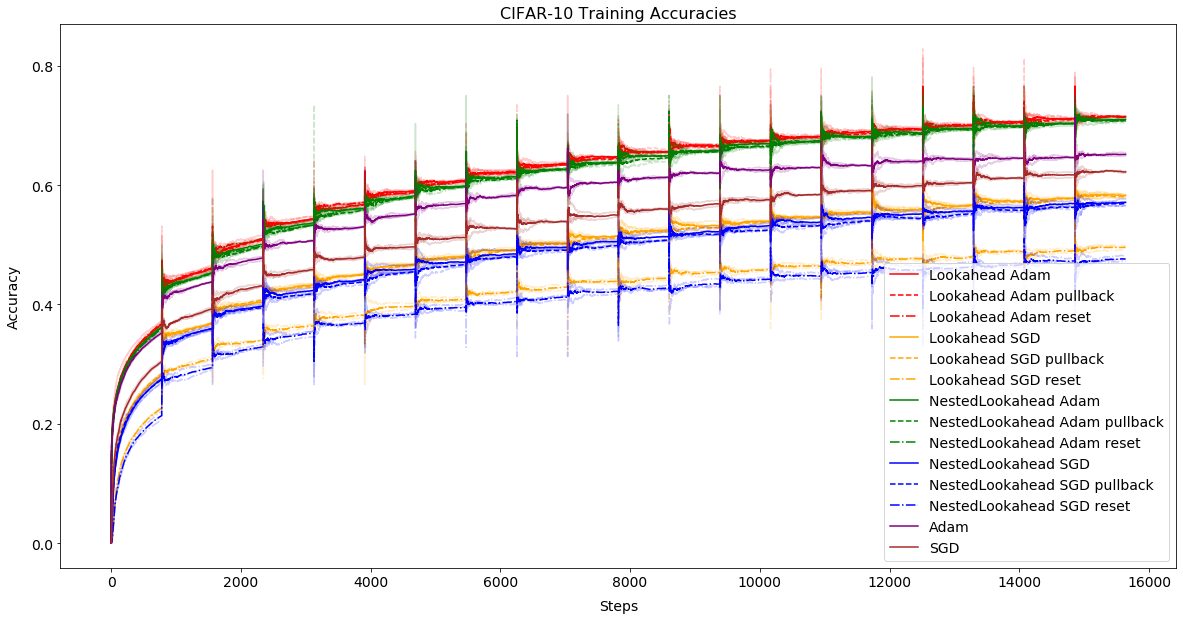

In [8]:
title_font = {'size':'16'}
axis_font = {'size':'14'}

plt.figure(figsize=(20,10))
plt.tick_params(labelsize=14)
plt.title(f"{name} Training Accuracies", **title_font)

for x in range(len(experiments)):
    styles = {'linestyle': get_style(experiments[x]), 'color': pallete[experiments[x]]}
    for i in range(folds):
        plt.plot(trains[x][:,i], alpha=0.2, **styles)
    plt.plot(trains[x].mean(axis=1), label=experiments[x], **styles)
    plt.xlabel('Steps', labelpad=10, **axis_font)
    plt.ylabel('Accuracy', labelpad=10, **axis_font)
    plt.legend(loc='lower right', prop=axis_font)
plt.savefig(f"plots/{to_file_base}_training_acc.png")
plt.show()

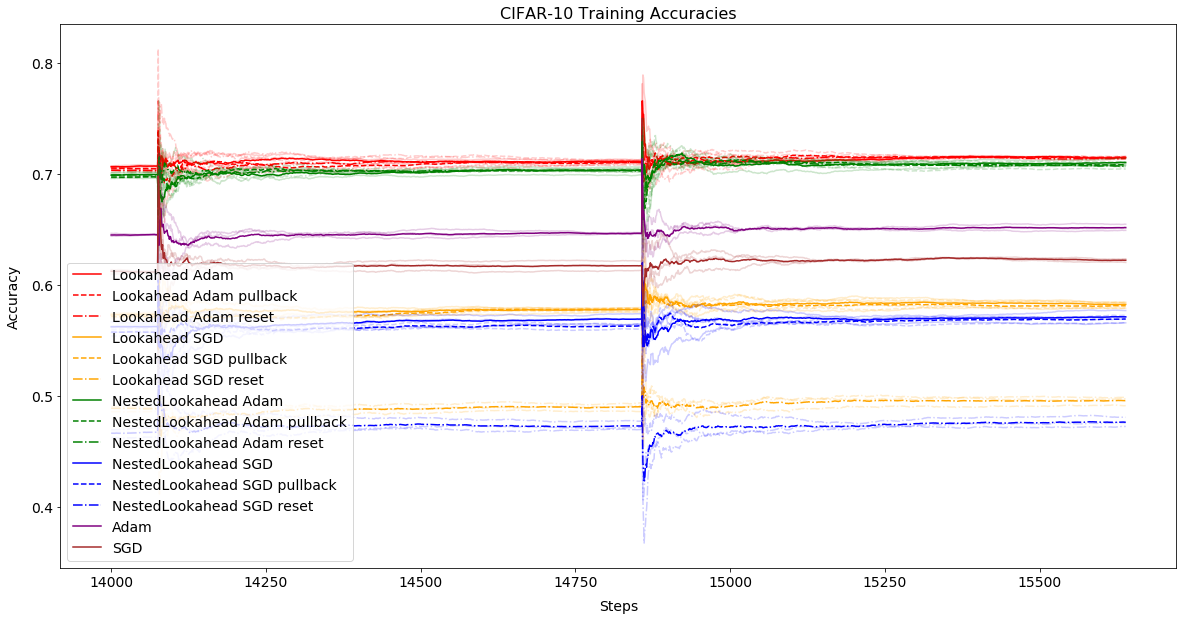

In [9]:
title_font = {'size':'16'}
axis_font = {'size':'14'}

plt.figure(figsize=(20,10))
plt.tick_params(labelsize=14)
plt.title(f"{name} Training Accuracies", **title_font)

for x in range(len(experiments)):
    styles = {'linestyle': get_style(experiments[x]), 'color': pallete[experiments[x]]}
    for i in range(folds):
        plt.plot(range(14000,15640), trains[x][14000:,i], alpha=0.2, **styles)
    plt.plot(range(14000,15640), trains[x][14000:,:].mean(axis=1), label=experiments[x], **styles)
    plt.xlabel('Steps', labelpad=10, **axis_font)
    plt.ylabel('Accuracy', labelpad=10, **axis_font)
    plt.legend(loc='lower left', prop=axis_font)
plt.savefig(f"plots/{to_file_base}_training_acc_tail.png")
plt.show()

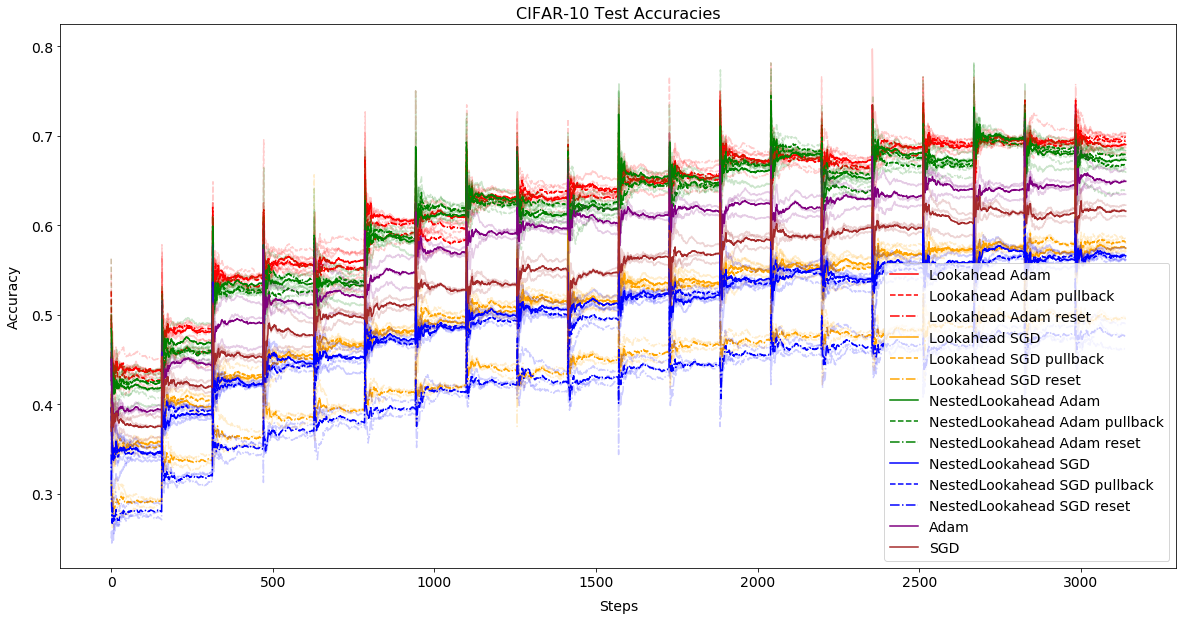

In [10]:
title_font = {'size':'16'}
axis_font = {'size':'14'}

plt.figure(figsize=(20,10))
plt.tick_params(labelsize=14)
plt.title(f"{name} Test Accuracies", **title_font)

for x in range(len(experiments)):
    styles = {'linestyle': get_style(experiments[x]), 'color': pallete[experiments[x]]}
    for i in range(folds):
        plt.plot(tests[x][:,i], alpha=0.2, **styles)
    plt.plot(tests[x].mean(axis=1), label=experiments[x], **styles)
    plt.xlabel('Steps', labelpad=10, **axis_font)
    plt.ylabel('Accuracy', labelpad=10, **axis_font)
    plt.legend(loc='lower right', prop=axis_font)
plt.savefig(f"plots/{to_file_base}_test_acc.png")
plt.show()

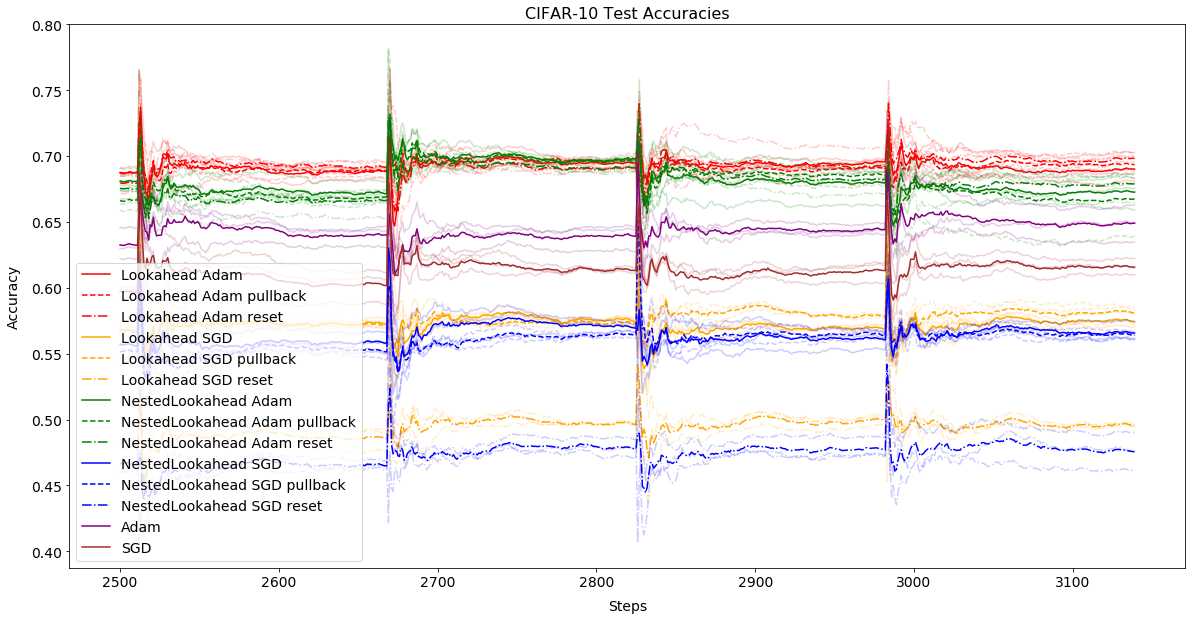

In [11]:

title_font = {'size':'16'}
axis_font = {'size':'14'}

plt.figure(figsize=(20,10))
plt.tick_params(labelsize=14)
plt.title(f"{name} Test Accuracies", **title_font)

for x in range(len(experiments)):
    styles = {'linestyle': get_style(experiments[x]), 'color': pallete[experiments[x]]}
    for i in range(folds):
        plt.plot(range(2500,3140), tests[x][2500:,i], alpha=0.2, **styles)
    plt.plot(range(2500,3140), tests[x][2500:,:].mean(axis=1), label=experiments[x], **styles)
    plt.xlabel('Steps', labelpad=10, **axis_font)
    plt.ylabel('Accuracy', labelpad=10, **axis_font)
    plt.legend(loc='lower left', prop=axis_font)
plt.savefig(f"plots/{to_file_base}_test_acc_tail.png")
plt.show()

## Hyperparameter Tuning

### RUN_CIFAR_VARIATION.SH


- weight decay: 0 vs. 0.001
- momentum: 0 vs. 0.9
- learning rate: 0.005, 0.0005 vs. 0.001
- k: 10 vs. 5
- a: 0.3, 0.7 vs. 0.5
- s: 10 vs. 5
- h: 0.3, 0.7 vs. 0.5


In [2]:
root = Path('cifar_variation_accuracies')
folds = 2
name = 'CIFAR-10'
to_file_base = 'cifar10_hyperparameter'

if not os.path.isdir('plots'):
    os.mkdir('plots')

In [4]:
def queries(values, keys=None, without=None):
    "Get `values` that contain all `keys` without any values specified in `without`"
    if isinstance(keys, str):
        values = [v for v in values if keys in v]
    elif isinstance(keys, Iterable):
        for k in keys:
            values = [v for v in values if k in v]
    if isinstance(without, str):
        values = [v for v in values if without not in v]
    elif isinstance(without, Iterable):
        for n in without:
            values = [v for v in values if n not in v]
    return sorted(values)

def length_test(A):
    "Checks that all objects in A are the same length"
    length = len(A[0])
    for obj in A[1:]:
        try:
            assert length == len(obj)
        except AssertionError:
            raise ValueError(f"{obj} should be size {length} but was size {len(obj)}")
    print("Length Test Passed")
    
def name_change(a):
    for i in range(len(a)):
        a[i] = a[i].replace('accs_','')
        a[i] = a[i].replace('_',' ')
        a[i] = a[i].replace(' a03',' (a=0.3,')
        a[i] = a[i].replace(' a07',' (a=0.7,')
        a[i] = a[i].replace('h07','h=0.7)')
        a[i] = a[i].replace('h03','h=0.3)')
        a[i] = a[i].replace(' k5',' (k=5,')
        a[i] = a[i].replace('s10','s=10)')
        a[i] = a[i].replace('s5','s=5)')
        a[i] = a[i].replace('k10','(k=10,')
        a[i] = a[i].replace(' half',' (half')
        a[i] = a[i].replace(' 5x',' (5x')
        a[i] = a[i].replace('mom0 wd0','(momentum=0, weight decay=0)')
        a[i] = a[i].replace(' mom0',' (momentum=0')
        a[i] = a[i].replace('lr','learning rate)')
        a[i] = a[i].replace('wd','weight decay=')
        a[i] = a[i].replace(' weight decay=0',' (weight decay=0)') if 'momentum' not in a[i] else a[i]
    return a

In [5]:
# get file names
files = os.listdir(root)
test_files = queries(files, ['.csv','test'])
train_files = queries(files, ['.csv','train'])

experiments = sorted(list(set([i[5:-6] for i in test_files])))

# Separate file names by experiment
exp_test = [] # test_files (names) separated by experiment
for exp in experiments:
    exp_test.append(queries(test_files, keys=exp))
    
length_test(exp_test)

experiments = name_change(experiments)
# filename_dict = dict(zip(sorted(test_files), sorted(experiments*2)))

# Load file data for each experiment
tests = [] # exp_test file data
for i in range(len(experiments)):
    test = []
    for p in exp_test[i]:
        p = root/Path(p)
        test.append(pd.read_csv(p, index_col=0).to_numpy())
    
    test = np.array(test)[:,:,0].T
    tests.append(test)
    
length_test(tests)
assert len(tests) == len(experiments)

experiment_dict = dict(zip(experiments, tests))

Length Test Passed
Length Test Passed


In [6]:
# get default values from `run_cifar.sh` experiment
root_defaults = Path('cifar_accuracies')
folds_defaults = 3

# get file names
files_defaults = os.listdir(root_defaults)
test_files_defaults = queries(files_defaults, ['.csv','test'])

experiments_defaults = sorted(list(set([i[5:-6] for i in test_files_defaults])))

exp_test_defaults = [] # test_files separated by experiment
for exp in experiments_defaults:
    if ('pullback' not in exp) and ('reset' not in exp):
        without=['pullback','reset']
    else:
        without=None

    exp_test_defaults.append(queries(test_files_defaults, keys=exp, without=without))
    
experiments_defaults = [exp[5:].replace('_',' ') for exp in experiments_defaults]

tests_defaults = []
for i in range(len(experiments_defaults)):
    test_defaults = []
    for p in exp_test_defaults[i]:
        p = root_defaults/Path(p)
        test_defaults.append(pd.read_csv(p, index_col=0).to_numpy())
    
    test_defaults = np.array(test_defaults)[:,:,0].T
    tests_defaults.append(test_defaults)
    
assert len(experiments_defaults) == len(tests_defaults)
experiments_defaults = list(map(lambda a: a + ' (default)', experiments_defaults))
experiment_dict_defaults = dict(zip(experiments_defaults, tests_defaults))

In [9]:
# run_cifar_variation.sh
adam_exp = queries(experiments, keys='Adam', without=['Lookahead','momentum=0'])
LA_adam_exp = queries(experiments, keys='Lookahead Adam', without='NestedLookahead')
NLA_adam_exp = queries(experiments, keys='NestedLookahead Adam')
sgd_exp = queries(experiments, keys='SGD', without='Lookahead')
LA_sgd_exp = queries(experiments, keys='Lookahead SGD', without='NestedLookahead')
NLA_sgd_exp = queries(experiments, keys='NestedLookahead SGD')

# run_cifar.sh
adam_exp_defaults = queries(experiments_defaults, keys='Adam', without='Lookahead')
LA_adam_exp_defaults = queries(experiments_defaults, keys='Lookahead Adam', without='NestedLookahead')
NLA_adam_exp_defaults = queries(experiments_defaults, keys='NestedLookahead Adam')
sgd_exp_defaults = queries(experiments_defaults, keys='SGD', without='Lookahead')
LA_sgd_exp_defaults = queries(experiments_defaults, keys='Lookahead SGD', without='NestedLookahead')
NLA_sgd_exp_defaults = queries(experiments_defaults, keys='NestedLookahead SGD')

# test lengths
length_test([LA_adam_exp, NLA_adam_exp, sgd_exp, LA_sgd_exp, NLA_sgd_exp])
length_test([LA_adam_exp_defaults, NLA_adam_exp_defaults, 
             LA_sgd_exp_defaults, NLA_sgd_exp_defaults])
length_test([adam_exp_defaults, sgd_exp_defaults])

Length Test Passed
Length Test Passed
Length Test Passed


In [11]:
colorlist = ['sienna','darkgreen','royalblue','red',
             'orange','darkcyan','darkviolet','lime','gold','fuchsia','olive','darkred']

In [12]:
def get_style(exp):
    "Gets linestyle for given experiment"
    if 'pullback' in exp:
        s = '--'
    elif 'reset' in exp:
        s = '-.'
    else:
        s = '-'
    return s

def create_plot(method, experiment_type, default):
    """Generates and saves a plot
    
    method: optimizer name used in title and saved file
    experiment_type: legend names for each set of values
    default: legend names for default values (from `run_cifar.sh`)"""
    title_font = {'size':'16'}
    axis_font = {'size':'14'}

    plt.figure(figsize=(15,10))
    plt.tick_params(labelsize=14)
    plt.title(f"{name} {method} Test Accuracies", **title_font)

    for i, exp in enumerate(experiment_type):
        styles = {'linestyle': '-', 'color': colorlist[i]}
        for i in range(folds):
            vals = experiment_dict[exp]
            plt.plot(vals[:,i], alpha=0.2, **styles)
        plt.plot(vals.mean(axis=1), label=exp, **styles)
        plt.xlabel('Steps', labelpad=10, **axis_font)
        plt.ylabel('Accuracy', labelpad=10, **axis_font)
        plt.legend(loc='lower right', prop=axis_font)

    for i, exp in enumerate(default):
        styles = {'linestyle': get_style(exp), 'color': colorlist[i+len(experiment_type)]}
        for i in range(folds_defaults):
            vals = experiment_dict_defaults[exp]
            plt.plot(vals[:,i], alpha=0.2, **styles)
        plt.plot(vals.mean(axis=1), label=exp, **styles)
        plt.xlabel('Steps', labelpad=10, **axis_font)
        plt.ylabel('Accuracy', labelpad=10, **axis_font)
        plt.legend(loc='lower right', prop=axis_font)

    plt.savefig(f"plots/{to_file_base}_{method.lower().replace(' ','_')}_test_acc.png")
    plt.show()

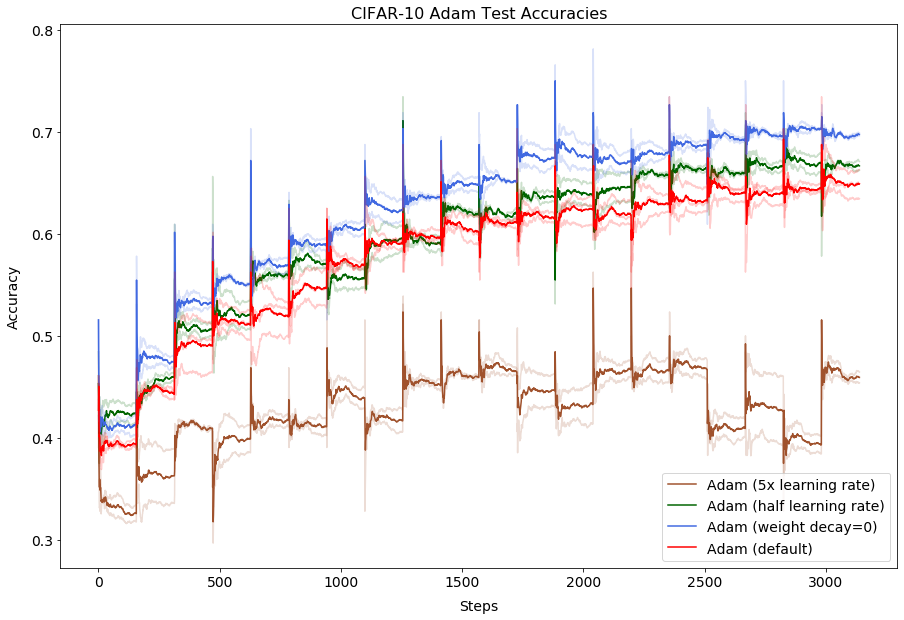

In [13]:
method = 'Adam'
experiment_type = adam_exp
default = adam_exp_defaults

create_plot(method, experiment_type, default)

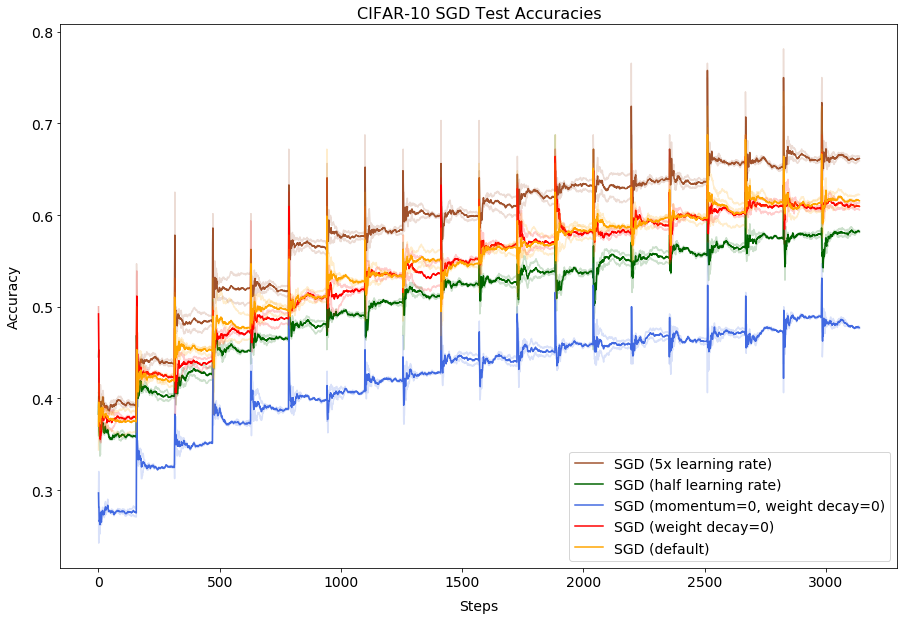

In [14]:
method = 'SGD'
experiment_type = sgd_exp
default = sgd_exp_defaults

create_plot(method, experiment_type, default)

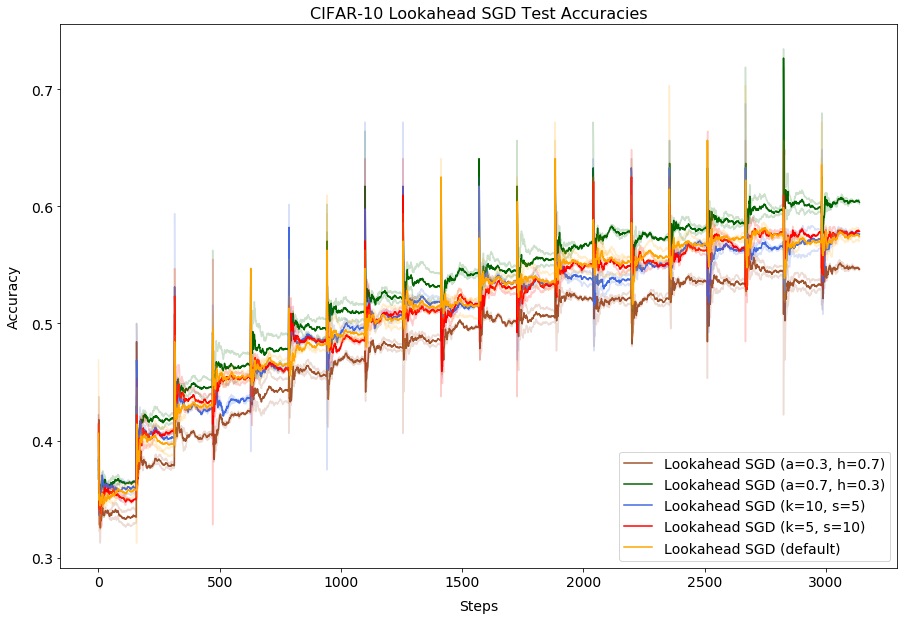

In [15]:
method = 'Lookahead SGD'
experiment_type = LA_sgd_exp
default = LA_sgd_exp_defaults
default = queries(default, without=['pullback','reset'])

create_plot(method, experiment_type, default)

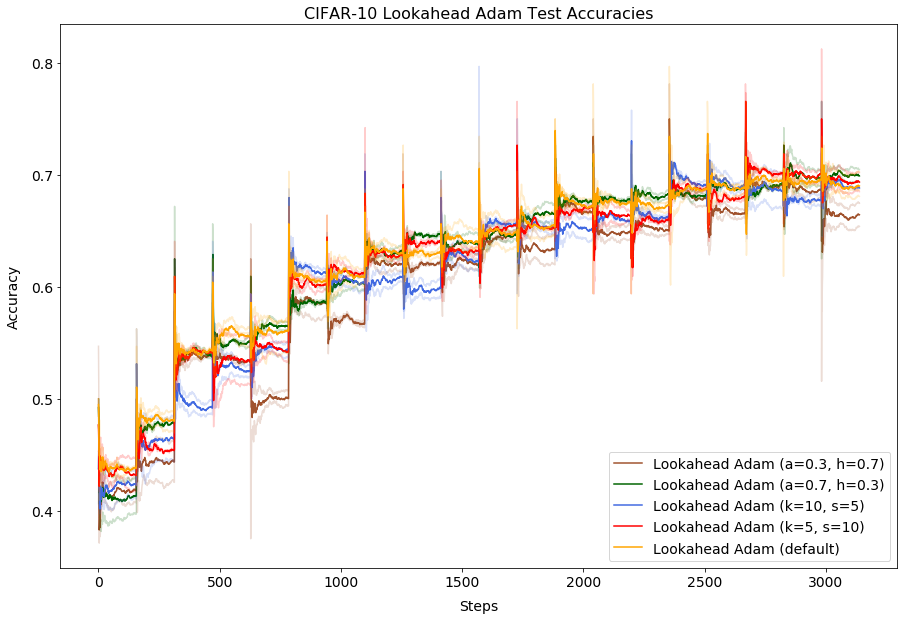

In [16]:
method = 'Lookahead Adam'
experiment_type = LA_adam_exp
default = LA_adam_exp_defaults
default = queries(default, without=['pullback','reset'])

create_plot(method, experiment_type, default)

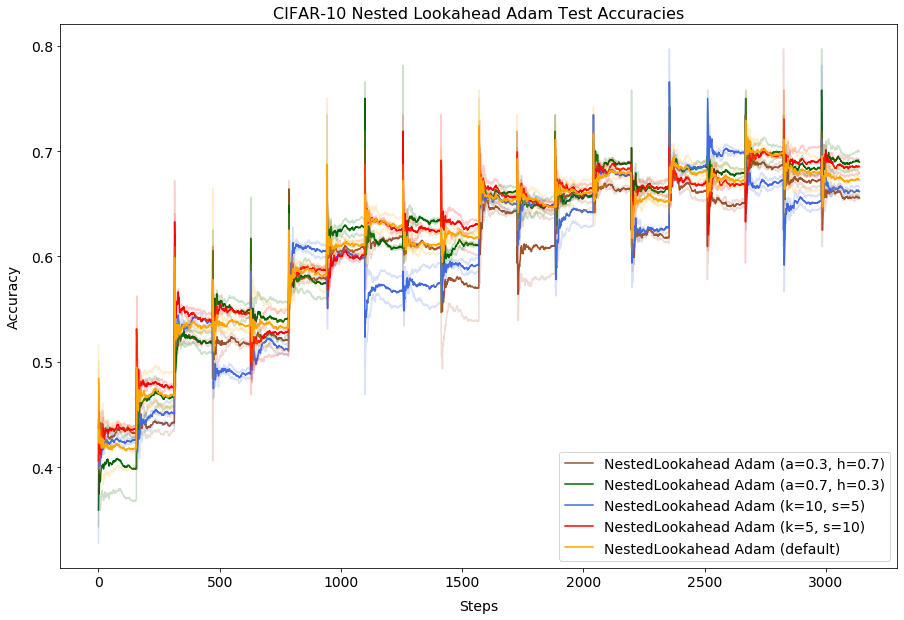

In [17]:
method = 'Nested Lookahead Adam'
experiment_type = NLA_adam_exp
default = NLA_adam_exp_defaults
default = queries(default, without=['pullback','reset'])

create_plot(method, experiment_type, default)

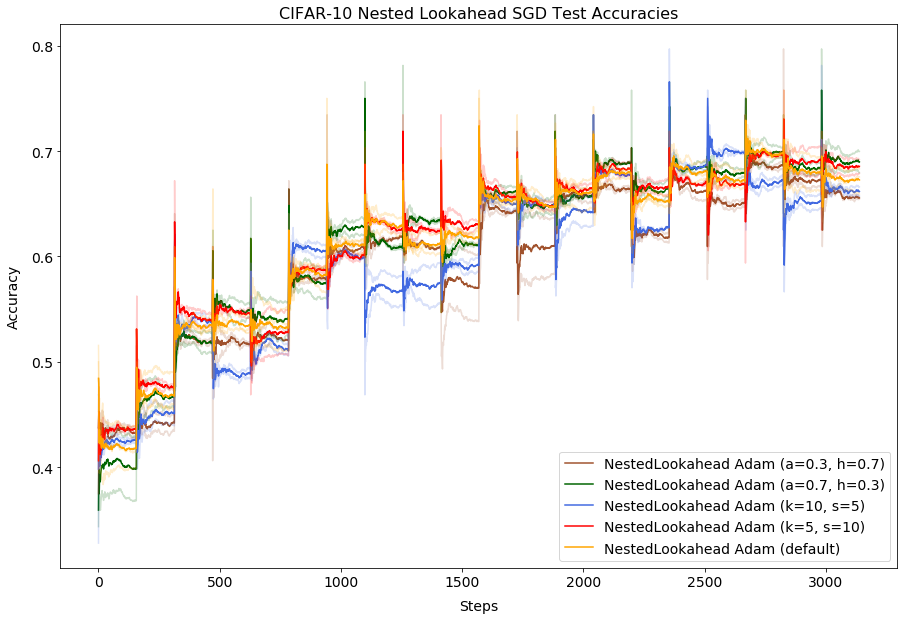

In [18]:
method = 'Nested Lookahead SGD'
experiment_type = NLA_adam_exp
default = NLA_adam_exp_defaults
default = queries(default, without=['pullback','reset'])

create_plot(method, experiment_type, default)

Parameters chosen for full run:

```
weight_decay=0
k=5
a=0.7
s=10
h=0.3
```

## Full Run 

### RUN_CIFAR_200EPOCHS.SH